<a href="https://colab.research.google.com/github/Juanvelam/Actividad_talentotech.github.io/blob/main/Vela_Juan_ActFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Actividad Final - Población Mundial**
####Juan Esteban Vela Mora
####Bootcamp - Jesús Rubio


#**1. LIBRERIAS.**

A continuación nos aseguramos que las librerías esten correctamente descargadas para poder trabajar con el código correspondiente.

In [2]:
!pip install mysql.connector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 55.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247953 sha256=0866bea06b3fc6ca248135a96d0457789af38f6fb3922eff3cb2821afc5742df
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177716d4a7d363d2bbe83bf6cf
Successfully built mysql.connector


In [3]:
!pip install beautifulsoup4
!pip install matplotlib
!pip install seaborn
!pip install pandas

#**2. REVISIÓN DE LINKS.**

Aquí se revisa si contiene tablas los links que se utilizan para sacar los datasets.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

urls = ['https://www.worldometers.info/world-population/world-population-by-year/']

archivo_datos = 'datos_extraidos_01.txt'

with open(archivo_datos, 'w', encoding='utf-8') as file:
    for url in urls:
        try:
            result = requests.get(url)

            if result.status_code == 200:
                soup = BeautifulSoup(result.text, 'lxml')

                titulo = soup.find('title').get_text(strip=True)

                file.write(f'Título: {titulo}\n')

                tablas = soup.find_all('table')
                num_tablas = len(tablas)

                if num_tablas > 0:
                    file.write(f'La página {url} contiene: {num_tablas} tablas.\n')
                else:
                    file.write(f'La página {url} no contiene tablas.\n')
            else:
                print(f'Error al acceder a {url}: Código de estado {result.status_code}')

            file.write('-' * 80 + '\n')

            time.sleep(1)

        except Exception as e:
            print(f'Ocurrió un error al procesar {url}: {e}')

print(f'Datos extraídos correctamente en: {archivo_datos}')

Datos extraídos correctamente en: datos_extraidos_01.txt


In [ ]:
import requests
from bs4 import BeautifulSoup
import time

urls = ['https://www.worldometers.info/world-population/world-population-projections/']

archivo_datos = 'datos_extraidos_02.txt'

with open(archivo_datos, 'w', encoding='utf-8') as file:
    for url in urls:
        try:
            result = requests.get(url)

            if result.status_code == 200:
                soup = BeautifulSoup(result.text, 'lxml')

                titulo = soup.find('title').get_text(strip=True)

                file.write(f'Título: {titulo}\n')

                tablas = soup.find_all('table')
                num_tablas = len(tablas)

                if num_tablas > 0:
                    file.write(f'La página {url} contiene: {num_tablas} tablas.\n')
                else:
                    file.write(f'La página {url} no contiene tablas.\n')
            else:
                print(f'Error al acceder a {url}: Código de estado {result.status_code}')

            file.write('-' * 80 + '\n')

            time.sleep(1)

        except Exception as e:
            print(f'Ocurrió un error al procesar {url}: {e}')

print(f'Datos extraídos correctamente en: {archivo_datos}')

Datos extraídos correctamente en: datos_extraidos_02.txt


#**3. CREACIÓN TABLAS**
En este punto realizamos la creación de las correspondientes tablas, como nuestros datasets contienen las mismas columnas, se creará una sola tabla con el fin de realizar el cruce de los datos directamente.

In [4]:
import mysql.connector

def create_table(db_name, table_name):
    """
    Crea una tabla SQL con las columnas especificadas.

    Args:
        db_name (str): Nombre de la base de datos.
        table_name (str): Nombre de la tabla.
    """
    db = mysql.connector.connect(
        host="bhxmllomby4jld9akpak-mysql.services.clever-cloud.com",
        user="uvffhsftqh56c5y0",
        password="YOWtz5xSqzlg4RyQTror",
        database="bhxmllomby4jld9akpak"
    )
    cursor = db.cursor()

    # Instrucción SQL corregida con espacios eliminados y columnas nulas
    sql_create = f"""
    CREATE TABLE IF NOT EXISTS `{table_name}` (
        Year INT NOT NULL PRIMARY KEY,
        WorldPopulation BIGINT NOT NULL,
        YearlyChange DECIMAL(5,2),  -- Puede ser NULL si los datos no están disponibles
        NetChange BIGINT,           -- Puede ser NULL si los datos no están disponibles
        Density FLOAT              -- Puede ser NULL si los datos del área terrestre no están disponibles
    );
    """

    cursor.execute(sql_create)
    db.commit()
    cursor.close()
    db.close()

if __name__ == "__main__":
    db_name = "your_database_name"  # Reemplácelo con el nombre de su base de datos
    table_name = "World_Population_AF_GC"  # Reemplácelo con el nombre de tabla deseado

    create_table(db_name, table_name)

    print(f"Tabla '{table_name}' creada correctamente en la base de datos '{db_name}'.")


Tabla 'World_Population_AF_GC' creada correctamente en la base de datos 'your_database_name'.


#**4 DATOS EN CLEVERCLOUD.**

Aquí colocamos el código referente a la extracción de los datos desde cara URL, como los datos contienen las mismas columnas, el proceso de extracción solo tomar agregar el código que permita leer una segunda URL y adicionalmente un código que omita el duplicado, o si existe, lo actualice.

In [7]:
import requests
from bs4 import BeautifulSoup
import mysql.connector

# Definir constantes globales para índices de columnas
YEAR_INDEX = 0
WORLDPOPULATION_INDEX = 1
YEARLYCHANGE_INDEX = 2
NETCHANGE_INDEX = 3
DENSITY_INDEX = 4

def clean_decimal(decimal_str):
    # Limpia los valores decimales removiendo comas y convirtiéndolos a float
    try:
        return float(decimal_str.replace(',', '').strip())
    except ValueError:
        return None  # Retorna None si no puede convertir el valor

def clean_percentage(percentage):
    # Limpia los porcentajes, quitando el símbolo '%' y convirtiéndolos a float
    try:
        return float(percentage.replace('%', '').replace(',', '.').strip())
    except ValueError:
        return None  # Retorna None si no puede convertir el valor

def clean_millions(population_str):
    """
    Converts a population string representation to millions.

    Args:
        population_str (str): The string representation of the population value.

    Returns:
        float or None: The population value in millions or None if invalid.
    """
    # Remove commas and whitespace, then convert to float
    try:
        population = float(population_str.replace(',', '').strip())
        # Divide by 1 million (10^6) to convert to millions
        return population / 1000000
    except ValueError:
        return None  # Return None if conversion fails

def process_row(celdas):
    if len(celdas) < 5:
        return None  # Retorna None si no hay suficientes celdas
    try:
        year = int(celdas[YEAR_INDEX].get_text(strip=True))
        WorldPopulation = clean_millions(celdas[WORLDPOPULATION_INDEX].get_text(strip=True))
        YearlyChange= clean_percentage(celdas[YEARLYCHANGE_INDEX].get_text(strip=True))
        NetChange = clean_millions(celdas[NETCHANGE_INDEX].get_text(strip=True))
        Density = clean_percentage(celdas[DENSITY_INDEX].get_text(strip=True))
        return (year, WorldPopulation, YearlyChange, NetChange, Density)
    except Exception as e:
        print(f"Error procesando fila: {e}")
        return None

def process_url(url, cursor, sql_insert, db):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tabla = soup.find('table')
    if not tabla:
        print("No se encontró tabla válida en la página.")
        return

    rows = tabla.find_all('tr')[1:]  # Omitir el encabezado
    for row in rows:
        celdas = row.find_all('td')
        if celdas:
            row_data = process_row(celdas)
            if row_data:
                cursor.execute(sql_insert, row_data)

    db.commit()
    print(f'Datos de la tabla exportados correctamente a la base de datos MySQL')

def main():
    db_config = {
        "host": "bhxmllomby4jld9akpak-mysql.services.clever-cloud.com",
        "user": "uvffhsftqh56c5y0",
        "password": "YOWtz5xSqzlg4RyQTror",
        "database": "bhxmllomby4jld9akpak"
    }
    sql_insert = """
    INSERT INTO World_Population_AF_GC (year, WorldPopulation, YearlyChange, NetChange, Density)
    VALUES (%s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE
        WorldPopulation = VALUES(WorldPopulation),
        YearlyChange = VALUES(YearlyChange),
        NetChange = VALUES(NetChange),
        Density = VALUES(Density)
    """
    url1 = 'https://www.worldometers.info/world-population/world-population-by-year/'
    url2 = 'https://www.worldometers.info/world-population/world-population-projections/'
    try:
        db = mysql.connector.connect(**db_config)
        cursor = db.cursor()
        process_url(url1, cursor, sql_insert, db)
        process_url(url2, cursor, sql_insert, db)
    except mysql.connector.Error as e:
        print(f'Error de MySQL: {str(e)}')
    finally:
        cursor.close()
        db.close()

if __name__ == "__main__":
    main()

Datos de la tabla exportados correctamente a la base de datos MySQL
Datos de la tabla exportados correctamente a la base de datos MySQL


#**5 GRÁFICOS.**

Aquí tenemos el código de los correspondientes gráficos realizados con el código y el dataset.

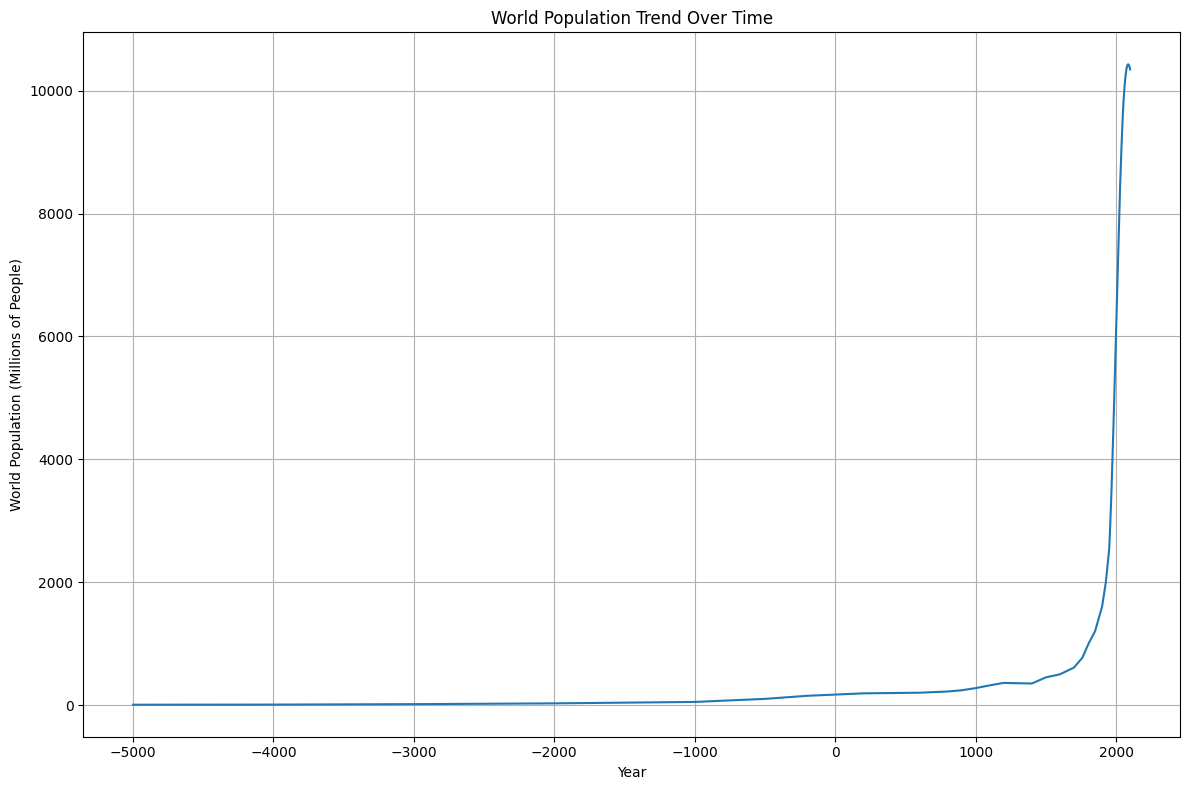

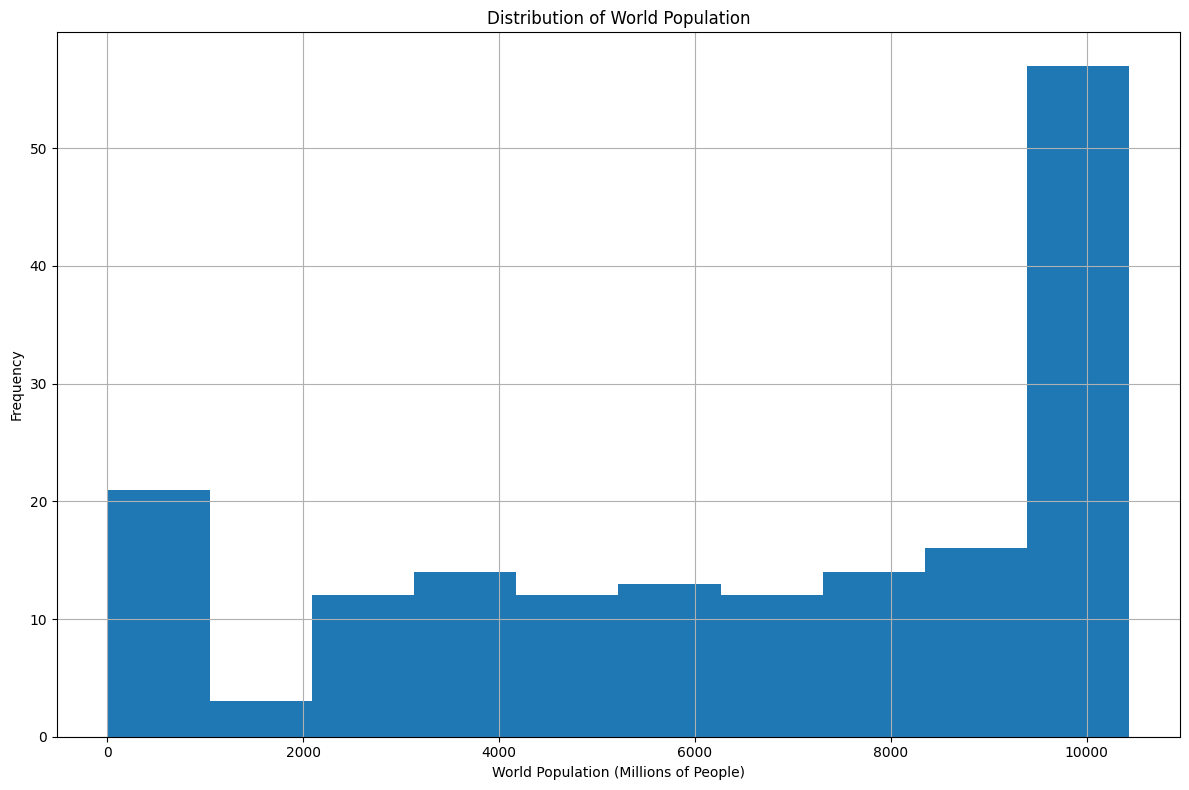

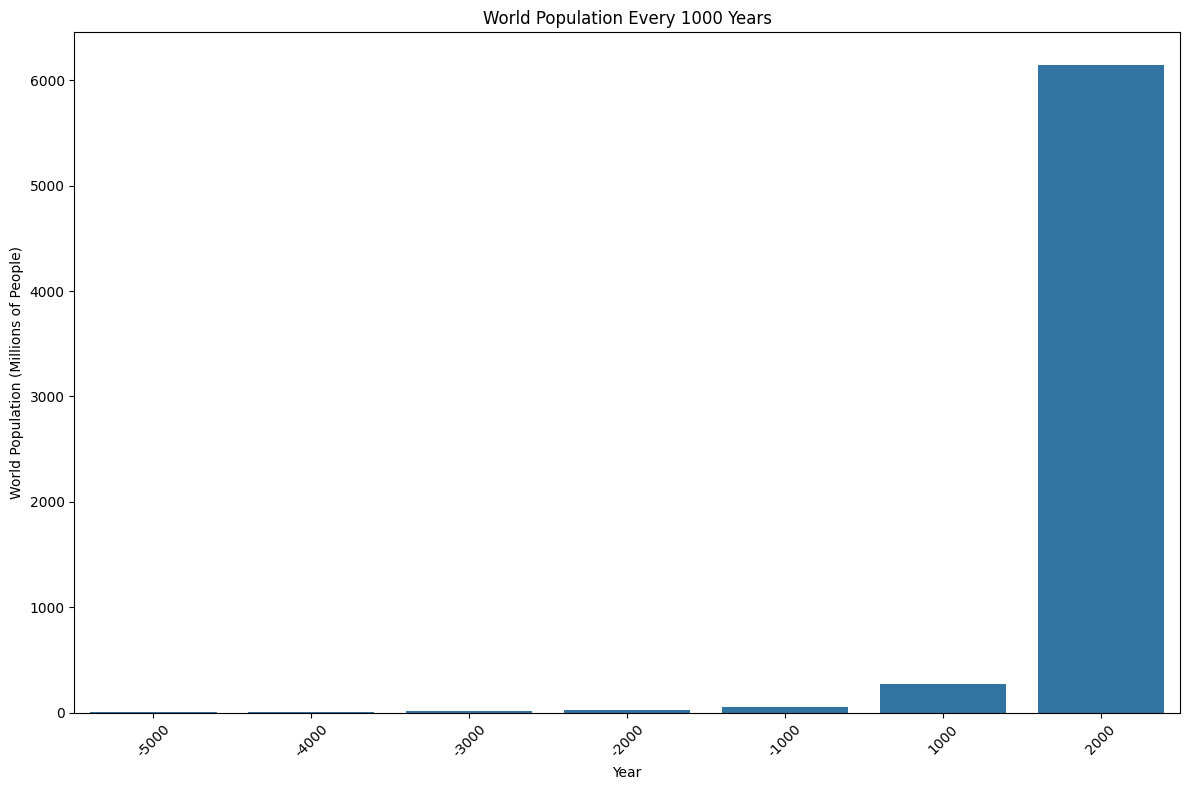

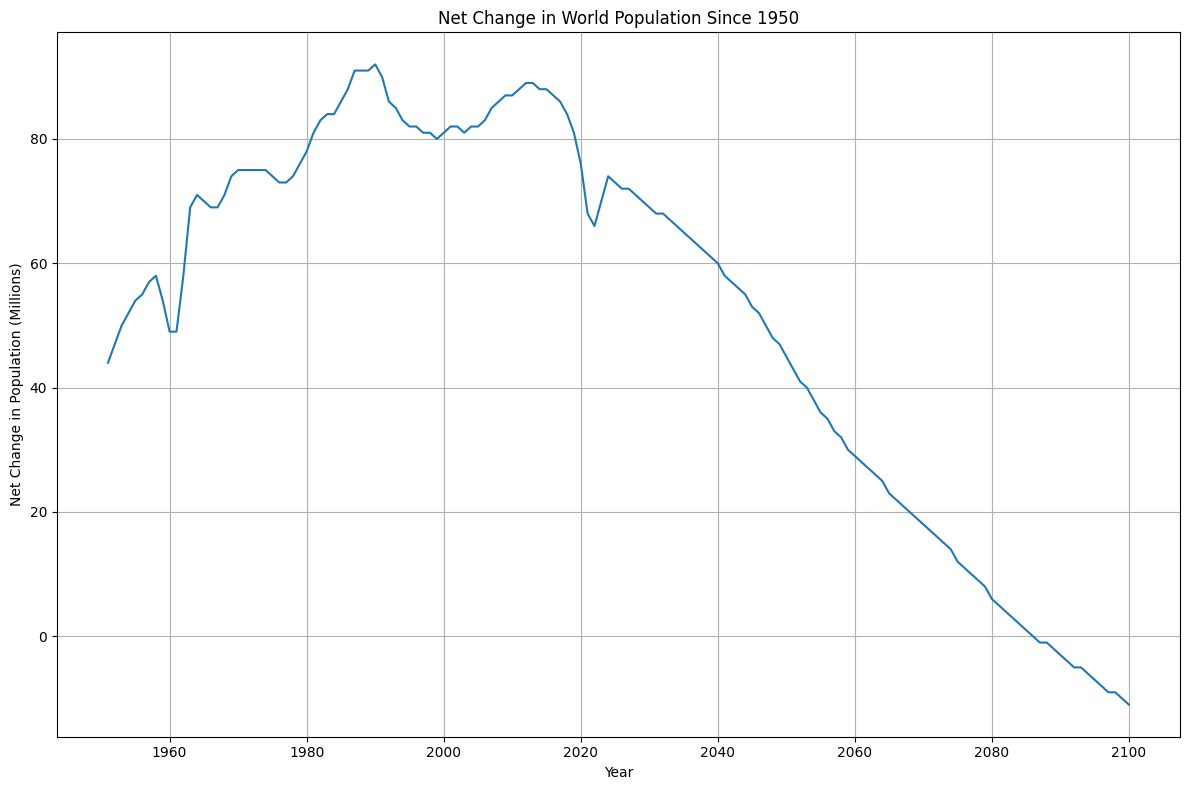

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mysql.connector

def connect_to_database():
    return mysql.connector.connect(
        host="bhxmllomby4jld9akpak-mysql.services.clever-cloud.com",
        user="uvffhsftqh56c5y0",
        password="YOWtz5xSqzlg4RyQTror",
        database="bhxmllomby4jld9akpak"
    )

def fetch_data(query):
    db = connect_to_database()
    cursor = db.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    cursor.close()
    db.close()
    return result


def plot_world_population_trend(limit=None):
  """
  This function generates a line plot showing the overall trend of world population.

  Args:
      limit (int, optional): The number of data points to include (if None, use all data). Defaults to None.
  """
  query = f"""
  SELECT Year, WorldPopulation
  FROM World_Population_AF_GC
  ORDER BY Year ASC;
  """
  result = fetch_data(query)
  df = pd.DataFrame(result, columns=['Year', 'WorldPopulation'])

  if limit:
      df = df.head(limit)  # Limit data points if specified

  plt.figure(figsize=(12, 8))
  plt.plot(df['Year'], df['WorldPopulation'])  # Line plot for year vs. population
  plt.xlabel('Year')
  plt.ylabel('World Population (Millions of People)')
  plt.title(f'World Population Trend Over Time')
  plt.grid(True)  # Add grid lines for readability
  plt.tight_layout()
  plt.show()

def plot_world_population_distribution(limit=None):
  """
  This function generates a histogram showing the distribution of world population values.

  Args:
      limit (int, optional): The number of data points to include (if None, use all data). Defaults to None.
  """
  query = f"""
  SELECT WorldPopulation
  FROM World_Population_AF_GC;
  """
  result = fetch_data(query)
  df = pd.DataFrame(result, columns=['WorldPopulation'])

  if limit:
      df = df.head(limit)  # Limit data points if specified

  plt.figure(figsize=(12, 8))
  plt.hist(df['WorldPopulation'], bins=10)  # Histogram with 10 bins
  plt.xlabel('World Population (Millions of People)')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of World Population')
  plt.grid(True)  # Add grid lines for readability
  plt.tight_layout()
  plt.show()

# Function to plot world population every 50 years (modify limit as needed)
def plot_world_population_every_1000_years(limit=10):
  query = f"""
  SELECT Year, WorldPopulation
  FROM World_Population_AF_GC
  WHERE Year % 1000 = 0  -- Filter for years divisible by 50
  ORDER BY Year ASC
  LIMIT {limit};
  """
  result = fetch_data(query)
  df = pd.DataFrame(result, columns=['Year', 'WorldPopulation'])

  plt.figure(figsize=(12, 8))
  sns.barplot(x="Year", y="WorldPopulation", data=df)  # Using seaborn for aesthetics
  plt.xlabel('Year')
  plt.ylabel('World Population (Millions of People)')
  plt.title(f'World Population Every 1000 Years')
  plt.xticks(rotation=45)  # Rotate x-axis labels for readability
  plt.tight_layout()
  plt.show()

def plot_net_population_change(limit=None):
  query = f"""
  SELECT Year, NetChange
  FROM World_Population_AF_GC
  WHERE NetChange IS NOT NULL  -- Filter for rows with NetChange data
  ORDER BY Year ASC;
  """
  result = fetch_data(query)
  if not result:
      print("No data found for NetChange. Skipping plot.")
      return

  df = pd.DataFrame(result, columns=['Year', 'NetChange'])

  plt.figure(figsize=(12, 8))
  plt.plot(df['Year'], df['NetChange'])
  plt.xlabel('Year')
  plt.ylabel('Net Change in Population (Millions)')  # Adjust label for Net Change
  plt.title('Net Change in World Population Since 1950')
  plt.grid(True)
  plt.tight_layout()
  plt.show()



if __name__ == "__main__":
    plot_world_population_trend()
    plot_world_population_distribution()
    plot_world_population_every_1000_years()
    plot_net_population_change()



#**6. CONCLUSIONES**

##Gráfico 1

El gráfico 1 evidencia la tendencia que ha tenido el crecimiento de la población a lo largo del tiempo, este gráfico nos muestra que ha habido un cremiento mayor desde después de la mitad del milenio (1000) hasta los tiempos actuales. Es decir que el crecimiento en la población del 5000AC hasta 1500DC es menor que del 1500DC hasta la actualidad.

##Gráfico 2

El gráfico 2 evidencia la frecuencia de los valores de la población en el tiempo, esto nos muestra que han habido al menos 2000 millones de personas en al menos 5 años en el tiempo. Mientras que 10000 millones de personas han existido en más de 50 años ene el tiempo.

##Gráfico 3

El gráfico 3 nos muestra de manera similar al gráfico 1 como ha cambiado la cantidad de la población mundial en el tiempo, en este caso como inciaba cada milenio. Como se evidencia del año 1000AC al 1000DC no hubo tanto crecimiento que del año 1000DC a 2000DC. Esto nos hace concluir que ha habido un gran crecimiento de la población, que muy seguramente esta dado por la tecnología y sus avances.

##Gráfico 4

El gráfico 4 es el cambio neto que ha tenido crecimiento de la población, añadiendo el cambio pronóstico que se tiene hasta el año 2100. Se evidencia un posible decrecimiento de la población desde el año en que estamos presente con un pequeño pico de aumento en la natalidad pero con posiblidad a que vuelva a disminuir. Podría estar basado en las expectativas de vida, la calidad de la misma, etc.


#**7.CONCLUSIÓN GENERAL**

Se ha evidenciado que el crecimiento poblacional ha sido mayor desde el año 1500 hasta la actualidad y menor desde el 5000AC hasta 1500DC, esto puede estar influido por los avances tecnológicos que han habido en esos momentos. Adicionalmente en los pronósticos del crecimiento poblacional desde 2020 hasta 2100 se evidencia un decrecimiento, es decir se detiene la tendencia creciente, por lo tanto los nacimientos, y empiezan a disminuir, generando menos población para la tierra.

Por otro lado es importante decir que no se realiza el proceso de creación de dashboard en power bi debido a que el dataset es corto y por lo tanto los gráficos presenciados son, de cierta manera, los que se pueden presentar, por ende no se quieren repetir.